![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

In this project, you will use regression models to predict the number of days a customer rents DVDs for.

As with most data science projects, you will need to pre-process the data provided, in this case, a csv file called rental_info.csv. Specifically, you need to:

Read in the csv file rental_info.csv using pandas.
Create a column named "rental_length_days" using the columns "return_date" and "rental_date", and add it to the pandas DataFrame. This column should contain information on how many days a DVD has been rented by a customer.
Create two columns of dummy variables from "special_features", which takes the value of 1 when:
The value is "Deleted Scenes", storing as a column called "deleted_scenes".
The value is "Behind the Scenes", storing as a column called "behind_the_scenes".
Make a pandas DataFrame called X containing all the appropriate features you can use to run the regression models, avoiding columns that leak data about the target.
Choose the "rental_length_days" as the target column and save it as a pandas Series called y.
Following the preprocessing you will need to:

Split the data into X_train, y_train, X_test, and y_test train and test sets, avoiding any features that leak data about the target variable, and include 20% of the total data in the test set.
Set random_state to 9 whenever you use a function/method involving randomness, for example, when doing a test-train split.
Recommend a model yielding a mean squared error (MSE) less than 3 on the test set

Save the model you would recommend as a variable named best_model, and save its MSE on the test set as best_mse.

In [2]:
def create_category(df, col):
    """
    Creates category column from numeric column
    :param df:
    :param col: column being converted to categories
    :return:
    """
    if col == 'amount':
        df[f"{col}.cat"] = pd.cut(df[col], bins=3, right=False, labels=['low', 'medium', 'high'])
    elif col == 'rental_rate':
        df[f"{col}.cat"] = pd.cut(df[col], bins=3, right=False, labels=['low', 'medium', 'high'])
    return df

def stratify_data(df, column) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Stratify data by category column
    :param df: dataframe
    :param column: column to stratify
    :return: dataframe with stratified data for training and testing
    """
    df = create_category(df, column)
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=9, stratify=df[f"{column}.cat"])
    return df_train.drop(columns=f"{column}.cat"), df_test.drop(columns=f"{column}.cat")

def train_test_preprocess(df):
    """
    :param df: 
    :return: 
    """
    # Create target column
    df['rental_length_days'] = (df['return_date'] - df['rental_date']).dt.days
    # Extract weekend from rental date and return date
    df['return_weekend'] = df['return_date'].dt.weekday.apply(lambda x: 1 if x == 5 else 1 if x == 6 else 0)
    df['rental_weekend'] = df['rental_date'].dt.weekday.apply(lambda x: 1 if x == 5 else 1 if x == 6 else 0)
    # create deleted scenes column
    df['deleted_scenes'] = df['special_features'].apply(lambda x: 1 if 'Deleted Scenes' in x else 0)
    # create behind the scenes col
    df['behind_the_scenes'] = df['special_features'].apply(lambda x: 1 if 'Behind the Scenes' in x else 0)
    # drop special features col
    df.drop(['special_features'], axis=1, inplace=True)
    # Rental lag
    # df['rental_lag'] = (df['rental_date'].dt.year - df['release_year'])
    # Replaces negative lag with 0
    # df['rental_lag'] = df['rental_lag'].apply(lambda x: 0 if x < 0 else x)
    # drop date columns
    df.drop(['rental_date', 'return_date'], axis=1, inplace=True)
    return df

def preprocess(stratify_col=None, stratify=False, test=False):
    """
    Preprocess data
    :param stratify: Set to False 
    :param stratify_col: column to stratify data
    :param test: Checks if test dataset
    :return: 
    """
    # load original dataset
    df = pd.read_csv('rental_info.csv', parse_dates=['rental_date', 'return_date'])
    # Checks for stratify condition
    if stratify:
        df_train, df_test = stratify_data(df, stratify_col)
    else:
        df_train, df_test = train_test_split(df, test_size=0.2, random_state=9)
    # Checks for if test data condition
    if not test:
        df = train_test_preprocess(df_train)
    else:
        df = train_test_preprocess(df_test)
    return df

# LOAD

In [3]:
rentals = pd.read_csv('rental_info.csv', parse_dates=['rental_date', 'return_date'])
rentals.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [4]:
del rentals

# EDA

In [5]:
# # Split rental data into training and test early to avoid data snooping bias
# rentals_train, rentals_test = train_test_split(rentals, test_size=0.2, random_state=9) # add stratification later on
# def create_category(df, col):
#     """
#     Creates category column from numeric column
#     :param df:
#     :param col: column being converted to categories
#     :return:
#     """
#     if col == 'amount':
#         df[f"{col}.cat"] = pd.cut(df[col], bins=3, right=False, labels=['low', 'medium', 'high'])
#     elif col == 'rental_rate':
#         df[f"{col}.cat"] = pd.cut(df[col], bins=3, right=False, labels=['low', 'medium', 'high'])
#     return df
# 
# def stratify_data(df, column) -> tuple[pd.DataFrame, pd.DataFrame]:
#     """
#     Stratify data by category column
#     :param df: dataframe
#     :param column: column to stratify
#     :return: dataframe with stratified data for training and testing
#     """
#     df = create_category(df, column)
#     df_train, df_test = train_test_split(df, test_size=0.2, random_state=9, stratify=df[f"{column}.cat"])
#     return df_train.drop(columns=f"{column}.cat"), df_test.drop(columns=f"{column}.cat")

# rentals_train, rentals_test = stratify_data(rentals, 'rental_rate')
# del rentals

In [6]:
rentals_train = preprocess()

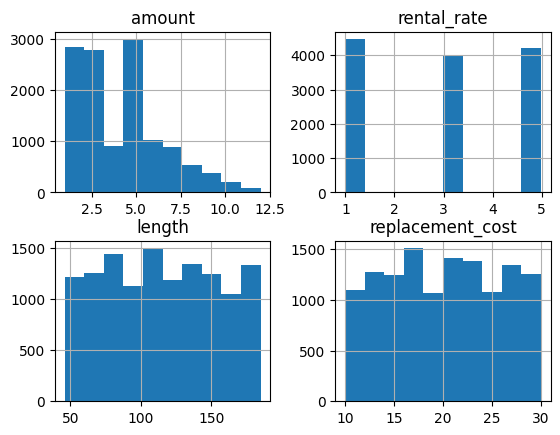

In [7]:
# show distribution
rentals_train[['amount', 'rental_rate', 'length', 'replacement_cost']].hist();

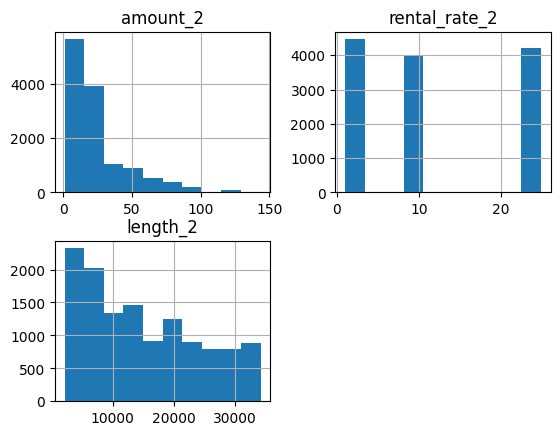

In [8]:
# show distribution
rentals_train[['amount_2', 'rental_rate_2', 'length_2']].hist();

In [9]:
# # Create target
# rentals_train['rental_length_days'] = (rentals_train['return_date'] - rentals_train['rental_date']).dt.days

In [10]:
# # Extract weekend from rental date and return date
# rentals_train['return_weekend'] = rentals_train['return_date'].dt.weekday.apply(lambda x: 1 if x == 5 else 1 if x == 6 else 0)
# rentals_train['rental_weekend'] = rentals_train['rental_date'].dt.weekday.apply(lambda x: 1 if x == 5 else 1 if x == 6 else 0)


In [11]:
print(rentals_train.select_dtypes('number').corr()['rental_length_days'])

amount                0.548484
release_year          0.010931
rental_rate          -0.004905
length               -0.002455
replacement_cost      0.007669
NC-17                -0.006194
PG                   -0.005258
PG-13                 0.014043
R                    -0.005597
amount_2              0.547058
length_2             -0.002086
rental_rate_2        -0.004736
rental_length_days    1.000000
return_weekend        0.002338
rental_weekend        0.012007
deleted_scenes       -0.008722
behind_the_scenes    -0.005293
Name: rental_length_days, dtype: float64


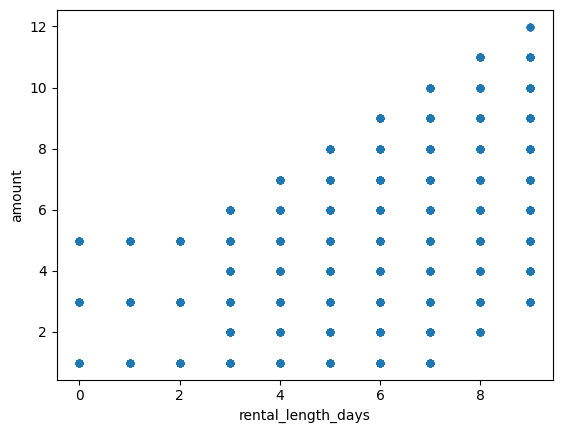

In [12]:
rentals_train.plot(y='amount', x='rental_length_days', kind='scatter');

# PREPROCESS

In [13]:
# rentals_train['deleted_scenes'] = rentals_train['special_features'].apply(lambda x: 1 if 'Deleted Scenes' in x else 0)
# rentals_train['behind_the_scenes'] = rentals_train['special_features'].apply(lambda x: 1 if 'Behind the Scenes' in x else 0)
# rentals_train.drop(['special_features'], axis=1, inplace=True)

In [14]:
# # Rental lag
# rentals_train['rental_lag'] = (rentals_train['rental_date'].dt.year - rentals_train['release_year'])
# rentals_train['rental_lag']

In [15]:
# negative_lags = rentals_train[rentals_train['rental_lag'] <= 0]
# print(len(negative_lags)/len(rentals_train))

In [16]:
# rentals_train['rental_lag'] = rentals_train['rental_lag'].apply(lambda x: 0 if x < 0 else x)

In [17]:
# rentals_train['rental_lag'].sum()

In [18]:
# # drop date columns
# rentals_train.drop(['rental_date', 'return_date'], axis=1, inplace=True)

# BUILD

In [19]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from category_encoders import TargetEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import StratifiedKFold

# Initialized skf
skf = StratifiedKFold(n_splits=5, random_state=9, shuffle=True)

num_attrib = ['amount', 'release_year', 'rental_rate', 'length', 'replacement_cost', 'amount_2', 'length_2', 'rental_rate_2',]


# Log scaler
log_scaler = FunctionTransformer(np.log1p, inverse_func=np.expm1)

# Preprocessing
log_preprocessing = ColumnTransformer([
    ('log_scaler', log_scaler, num_attrib),
], remainder='passthrough')

std_preprocessing = ColumnTransformer([
    ('std_scaler', StandardScaler(), num_attrib),
], remainder='passthrough')

# Pipeline
lin_log_pipeline = Pipeline([
    ('preprocessing', log_preprocessing),
    ('regressor', TransformedTargetRegressor(
        regressor=LinearRegression(n_jobs=-1),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

lin_std_pipeline = Pipeline([
    ('preprocessing', std_preprocessing),
    ('regressor', TransformedTargetRegressor(
        regressor=LinearRegression(n_jobs=-1),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

tree_pipeline_no_processing = Pipeline([
    ('treeRegressor', DecisionTreeRegressor(random_state=9))
])

tree_pipeline_log_processing = Pipeline([
    ("preprocessing", log_preprocessing),
    ('treeRegressor', DecisionTreeRegressor(random_state=9))
])

tree_pipeline_std_processing = Pipeline([
    ("preprocessing", std_preprocessing),
    ('treeRegressor', DecisionTreeRegressor(random_state=9))
])

forest_pipeline_no_processing = Pipeline([
    ('forestRegressor', RandomForestRegressor(random_state=9))
])

forest_pipeline_log_processing = Pipeline([
    ("preprocessing", log_preprocessing),
    ('forestRegressor', RandomForestRegressor(random_state=9))
])

forest_pipeline_std_processing = Pipeline(steps=[
    ("preprocessing", std_preprocessing),
    ('forestRegressor', RandomForestRegressor(random_state=9))
])

In [20]:
# Split training data in features and target
X_train = rentals_train.drop(columns=['rental_length_days'])
y_train = rentals_train['rental_length_days']

# Fit log transformed pipeline for Linear reg
lin_log_pipeline.fit(X_train, y_train)
# Fit std transformed pipeline for linear reg
lin_std_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std_scaler',
                                                  StandardScaler(),
                                                  ['amount', 'release_year',
                                                   'rental_rate', 'length',
                                                   'replacement_cost',
                                                   'amount_2', 'length_2',
                                                   'rental_rate_2'])])),
                ('regressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LinearRegression(n_jobs=-1)))])

# EVALUATE

In [21]:
def evaluate_mse(model, features, labels):
    """
    Evaluates models mse
    :param model: 
    :param features: 
    :param labels: 
    :return: 
    """
    pred = model.predict(features)
    pred_mse = mean_squared_error(labels, pred)
    
    print(f"model mse: {pred_mse}")
    return pred_mse

In [22]:
def evaluate_cv_mse(model, features, labels):
    """
    Evaluates models mse using cross validation
    :param model: 
    :param features: 
    :param labels: 
    :return: 
    """
    cv_mse = (-cross_val_score(model, features, labels, cv=skf, scoring='neg_root_mean_squared_error')) **2
    cv_mse = pd.Series(cv_mse)
    print(cv_mse.describe())
    return cv_mse

In [23]:
# Evaluate  --linear model
log_pipe_mse = evaluate_mse(lin_log_pipeline, X_train, y_train)
std_pipe_mse = evaluate_mse(lin_std_pipeline, X_train, y_train)

model mse: 3.7621879200878463
model mse: 3.9673519126868344


In [24]:
# Evaluate using cross validation -- linear model
lin_log_cv_mse = evaluate_cv_mse(lin_log_pipeline, X_train, y_train)

print('----------------------')

lin_std_cv_mse = evaluate_cv_mse(lin_std_pipeline, X_train, y_train)

count    5.000000
mean     3.775240
std      0.077913
min      3.672308
25%      3.710971
50%      3.823957
75%      3.825434
max      3.843532
dtype: float64
----------------------
count    5.000000
mean     3.981834
std      0.145969
min      3.760952
25%      3.914216
50%      4.036757
75%      4.070595
max      4.126652
dtype: float64


In [25]:
# Compare the ratio mean cv mses -- linear model
print("linear regressor with log processing",lin_log_cv_mse.mean() / y_train.mean() * 100)
print("linear regressor with standard scaler processing",lin_std_cv_mse.mean()/ y_train.mean() * 100)
print("Both means are better than Baseline mean")

linear regressor with log processing 83.3395627394581
linear regressor with standard scaler processing 87.9001944890524
Both means are better than Baseline mean


In [26]:
# WE CAN CHANGE THE STRATIFICATION USED
# here preprocess() # Put values for stratify col and test

In [27]:
# Decision tree
tree_pipeline_no_processing.fit(X_train, y_train)
tree_pipeline_log_processing.fit(X_train, y_train)
tree_pipeline_std_processing.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std_scaler',
                                                  StandardScaler(),
                                                  ['amount', 'release_year',
                                                   'rental_rate', 'length',
                                                   'replacement_cost',
                                                   'amount_2', 'length_2',
                                                   'rental_rate_2'])])),
                ('treeRegressor', DecisionTreeRegressor(random_state=9))])

In [28]:
# Evaluate trees
tree_no_processing_mse = evaluate_mse(tree_pipeline_no_processing, X_train, y_train)
tree_log_processing_mse = evaluate_mse(tree_pipeline_log_processing, X_train, y_train)
tree_std_processing_mse = evaluate_mse(tree_pipeline_std_processing, X_train, y_train)

model mse: 0.9536242104889646
model mse: 0.9536242104889646
model mse: 0.9536242104889646


In [29]:
# Evaluate trees using cv
tree_no_processing_cv_mse = evaluate_cv_mse(tree_pipeline_no_processing, X_train, y_train)
print('----------------------')
tree_log_processing_cv_mse = evaluate_cv_mse(tree_pipeline_log_processing, X_train, y_train)
print('----------------------')
tree_std_processing_cv_mse = evaluate_cv_mse(tree_pipeline_std_processing, X_train, y_train)

count    5.000000
mean     2.932831
std      0.106244
min      2.825159
25%      2.826510
50%      2.937193
75%      3.026209
max      3.049087
dtype: float64
----------------------
count    5.000000
mean     2.936114
std      0.113846
min      2.818288
25%      2.826498
50%      2.940038
75%      3.026081
max      3.069665
dtype: float64
----------------------
count    5.000000
mean     2.937741
std      0.114293
min      2.817830
25%      2.820204
50%      2.960967
75%      3.027932
max      3.061774
dtype: float64


In [30]:
# Random forest model
forest_pipeline_no_processing.fit(X_train, y_train)
forest_pipeline_log_processing.fit(X_train, y_train)
forest_pipeline_std_processing.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std_scaler',
                                                  StandardScaler(),
                                                  ['amount', 'release_year',
                                                   'rental_rate', 'length',
                                                   'replacement_cost',
                                                   'amount_2', 'length_2',
                                                   'rental_rate_2'])])),
                ('forestRegressor', RandomForestRegressor(random_state=9))])

In [31]:
# Evaluate forest
forest_no_processing_mse = evaluate_mse(forest_pipeline_no_processing, X_train, y_train)
forest_log_processing_mse = evaluate_mse(forest_pipeline_log_processing, X_train, y_train)
forest_std_processing_mse = evaluate_mse(forest_pipeline_std_processing, X_train, y_train)

model mse: 1.0330288552656226
model mse: 1.0329741507868613
model mse: 1.0330288011736648


In [32]:
# Evaluate trees using cv
forest_no_processing_cv_mse = evaluate_cv_mse(forest_pipeline_no_processing, X_train, y_train)
print('----------------------')
forest_log_processing_cv_mse = evaluate_cv_mse(forest_pipeline_log_processing, X_train, y_train)
print('----------------------')
forest_std_processing_cv_mse = evaluate_cv_mse(forest_pipeline_std_processing, X_train, y_train)

count    5.000000
mean     2.291535
std      0.101930
min      2.153623
25%      2.231072
50%      2.296152
75%      2.381653
max      2.395174
dtype: float64
----------------------
count    5.000000
mean     2.292029
std      0.098731
min      2.158808
25%      2.234325
50%      2.294282
75%      2.378947
max      2.393784
dtype: float64
----------------------
count    5.000000
mean     2.292133
std      0.100654
min      2.154743
25%      2.234918
50%      2.295917
75%      2.378734
max      2.396351
dtype: float64


In [33]:
def random_search(pipeline, param, features, labels):
    """
    Perform random search on pipelines
    :param pipeline: 
    :param param:
    :param features:
    :param labels: 
    :return: 
    """
    # Randomized Grid Search for tree no processing
    random_search_model = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param,
        n_iter=10,
        scoring='neg_root_mean_squared_error',
        cv=skf,
        random_state=9
    )

    random_search_model.fit(features, labels)
    return random_search_model

In [34]:
def random_search_results(model):
    """
    Outputs results
    :param model: random search instance
    :return: best model
    """
    # Get best params 
    print("Best parametes: ", model.best_params_)
    # Get best score(MSE)
    print("Best score: ", (-model.best_score_) ** 2)
    return model.best_estimator_

In [35]:
# Fine tune models
# Decision Tree
from sklearn.model_selection import RandomizedSearchCV
import random
# random.randint(1, 5)
# Define hyperparameter space
param_dist = {
    # 'treeRegressor__n_estimators': [10, 50, 100],
    'treeRegressor__max_depth': [random.randint(1, 100)],
    'treeRegressor__min_samples_split': [random.randint(1, 10)],
    'treeRegressor__min_samples_leaf': [random.randint(1, 10)],   
}

param_dist_fr = {
    'forestRegressor__n_estimators': [10, 50, 100],
    'forestRegressor__max_depth': list(range(1, 21)),
    'forestRegressor__min_samples_split': list(range(1, 11)),
    'forestRegressor__min_samples_leaf': list(range(1, 11)),
}

In [36]:
# Randomized Grid Search for tree no processing
random_search_tree = random_search(tree_pipeline_no_processing, param_dist, X_train, y_train)
# Results for no processing pipeline
best_tree_no_processing_model = random_search_results(random_search_tree)

Best parametes:  {'treeRegressor__min_samples_split': 8, 'treeRegressor__min_samples_leaf': 6, 'treeRegressor__max_depth': 57}
Best score:  2.454204687659814


In [37]:
# Randomized Grid Search for tree log processing
random_search_tree_log = random_search(tree_pipeline_log_processing, param_dist, X_train, y_train)
# Results for log processing pipeline
best_tree_log_processing_model = random_search_results(random_search_tree_log)


Best parametes:  {'treeRegressor__min_samples_split': 8, 'treeRegressor__min_samples_leaf': 6, 'treeRegressor__max_depth': 57}
Best score:  2.4492540268828344


In [38]:

# Randomized Grid Search for tree std processing
random_search_tree_std = random_search(tree_pipeline_std_processing, param_dist, X_train, y_train)
# Results for log processing pipeline
best_tree_std_processing_model = random_search_results(random_search_tree_std)

Best parametes:  {'treeRegressor__min_samples_split': 8, 'treeRegressor__min_samples_leaf': 6, 'treeRegressor__max_depth': 57}
Best score:  2.4525243497453286


In [39]:
# Randomized Grid Search for forest no processing
random_search_forest = random_search(forest_pipeline_no_processing, param_dist_fr, X_train, y_train)
# Results for no processing pipeline
best_fr_no_processing_model = random_search_results(random_search_forest)

Best parametes:  {'forestRegressor__n_estimators': 100, 'forestRegressor__min_samples_split': 8, 'forestRegressor__min_samples_leaf': 6, 'forestRegressor__max_depth': 16}
Best score:  2.1519454229861728


In [40]:

# Randomized Grid Search for forest log processing
random_search_forest_log = random_search(forest_pipeline_log_processing, param_dist_fr, X_train, y_train)
# Results for no processing pipeline
best_fr_log_processing_model = random_search_results(random_search_forest_log)

Best parametes:  {'forestRegressor__n_estimators': 100, 'forestRegressor__min_samples_split': 8, 'forestRegressor__min_samples_leaf': 6, 'forestRegressor__max_depth': 16}
Best score:  2.151400134601393


In [41]:
# Randomized Grid Search for forest std processing
random_search_forest_std = random_search(forest_pipeline_std_processing, param_dist_fr, X_train, y_train)
# Results for no processing pipeline
best_fr_std_processing_model = random_search_results(random_search_forest_std)


Best parametes:  {'forestRegressor__n_estimators': 100, 'forestRegressor__min_samples_split': 8, 'forestRegressor__min_samples_leaf': 6, 'forestRegressor__max_depth': 16}
Best score:  2.1519944269043614


### Evaluate best model on test set

In [42]:
# Get test data
rentals_test = preprocess(test=True)
# split into X_test and y_test
X_test = rentals_test.drop('rental_length_days', axis=1)
y_test = rentals_test['rental_length_days']

In [43]:
# best model
y_pred = best_fr_log_processing_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred)
final_mse

2.1492708924273054

In [44]:
# import pickle
# 
# # Save model
# with open("movie_rental_model.pkl", "wb") as f:
#     pickle.dump(best_fr_log_processing_model, f)


# COMMUNICATE

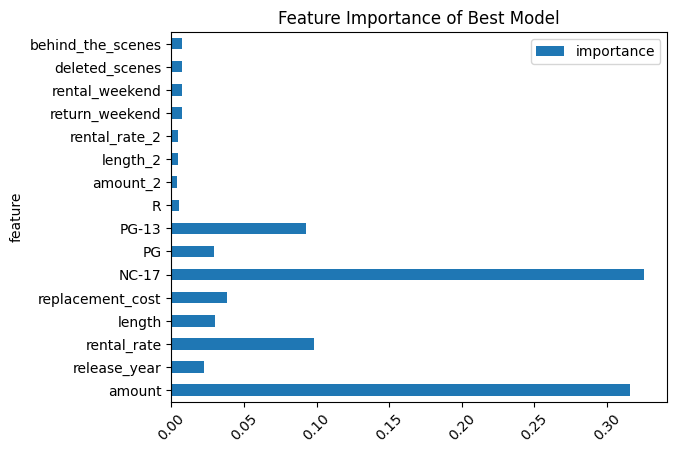

In [47]:
# plot feature importance
features_importance = best_fr_log_processing_model['forestRegressor'].feature_importances_

# create dataframe
df_features_importance = pd.DataFrame({'feature': X_test.columns, 'importance': features_importance})

# plot features
df_features_importance.plot(x="feature", y="importance",kind='barh')
plt.xticks(rotation=45);
plt.title('Feature Importance of Best Model');

## DEMO MODEL

In [50]:
import gradio as gr
import pickle
import pandas as pd

# Load the trained model
with open('./movie_rental_model.pkl', 'rb') as f:
    model = pickle.load(f)

def preprocess_input(amount, release_year, rental_rate,
                     length, replacement_cost, NC_17, PG, PG_13, R,
                     return_weekend, rental_weekend, deleted_scenes,
                     behind_the_scenes):
    # Create a DataFrame for the model input
    input_data = pd.DataFrame({
        'amount': [amount],
        'release_year': [release_year],
        'rental_rate': [rental_rate],
        'length': [length],
        'replacement_cost': [replacement_cost],
        'NC-17': [1 if NC_17 == 'Yes' else 0],
        'amount_2': [amount**2] ,
        'length_2': [length**2],
        'rental_rate_2': [rental_rate**2],
        'PG': [1 if PG == 'Yes' else 0],
        'PG-13': [1 if PG_13 == 'Yes' else 0],
        'R': [1 if R == 'Yes' else 0],
        'return_weekend': [1 if return_weekend == 'Yes' else 0],
        'rental_weekend': [1 if rental_weekend == 'Yes' else 0],
        'deleted_scenes': [1 if deleted_scenes == 'Yes' else 0],
        'behind_the_scenes': [1 if behind_the_scenes == 'Yes' else 0],
    })
    return input_data

# Define prediction function
def predict_rent_duration(amount, release_year, rental_rate,
                          length, replacement_cost, NC_17, PG, PG_13, R,
                          return_weekend, rental_weekend, deleted_scenes,
                          behind_the_scenes):
    input_data = preprocess_input(amount, release_year, rental_rate,
                                  length, replacement_cost, NC_17, PG, PG_13, R,
                                  return_weekend, rental_weekend, deleted_scenes,
                                  behind_the_scenes)
    prediction = model.predict(input_data)
    return f"Predicted Movie Duration:{round(prediction[0])} days"

# Create Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# Movie Rental Duration Prediction")

    with gr.Row():
        amount = gr.Number(label='Price of DVD')
        release_year = gr.Number(label='Release Year')
        rental_rate = gr.Number(label='Rental Rate')
        length = gr.Number(label='Length of Movie')
        replacement_cost = gr.Number(label='Replacement Cost')
        NC_17 = gr.Radio(label='NC-17', choices=["Yes", "No"])
        PG = gr.Radio(label='PG', choices=["Yes", "No"])
        PG_13 = gr.Radio(label='PG-13', choices=["Yes", "No"])
        R = gr.Radio(label='R', choices=["Yes", "No"])
        return_weekend = gr.Radio(label='Return Weekend', choices=["Yes", "No"])
        rental_weekend = gr.Radio(label='Rental Weekend', choices=["Yes", "No"])
        deleted_scenes = gr.Radio(label='Deleted Scenes', choices=["Yes", "No"])
        behind_the_scenes = gr.Radio(label='Behind the Scenes', choices=["Yes", "No"])
    predict_button = gr.Button("Predict")

    output = gr.Text(label="Prediction Results")

    predict_button.click(
        fn=predict_rent_duration,
        inputs=[amount, release_year, rental_rate,
                length, replacement_cost, NC_17, PG, PG_13, R,
                return_weekend, rental_weekend, deleted_scenes,
                behind_the_scenes],
        outputs=output
    )

# Run the app
demo.launch(share=True)


* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://ef9fd9bc7cc4938c8a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
